In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

In [4]:
# load the mnist dataset
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [6]:
X_train.reshape(-1, 28*28).shape

(60000, 784)

In [8]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

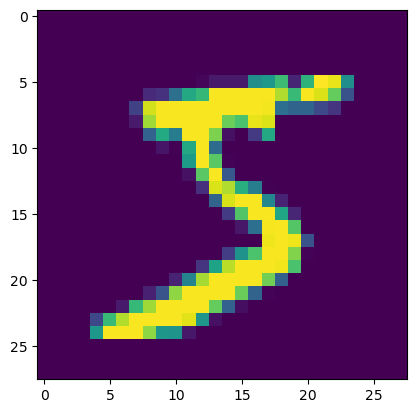

In [10]:
plt.imshow(X_train[0])

In [14]:
import torch
import torch.nn as nn

class BroNet(torch.nn.Module):
    def __init__(self):
        super(BroNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x
    
model = BroNet()
model(torch.tensor(X_train[0:10].reshape((-1, 28*28))).float())

tensor([[ 26.6586, -29.1754,  13.0447, -27.4691,   9.6391,   9.0160,  14.4893,
          -4.0376, -10.1101,  24.1493],
        [ 15.9760,  -0.1941, -14.9250, -16.2109,   1.3434,  12.6124,  18.4761,
          -5.6790, -16.9233,  35.8945],
        [-17.9334,  -5.4769, -21.8578, -23.0516,  -2.9256,  12.3874,  10.1180,
           0.7221,  -2.0800,   1.6221],
        [  3.4638,  16.9858, -16.5124, -12.9745,  27.2385,  22.3890,  19.3569,
          10.9795, -14.4717,  40.3569],
        [  8.2468,  -5.6863, -10.5097, -26.2778, -10.8875,  24.4677, -11.0871,
           2.3511, -24.9549,  36.5295],
        [ 44.0131,  -3.1956, -43.4219, -54.0742,  -9.0967,  22.7206,  -5.8632,
          -8.3918, -27.0589,  39.1365],
        [ 12.0029, -10.2049, -17.4319, -23.1291,   1.1084,   8.6828,   6.9239,
          14.5885, -32.3670,   6.9947],
        [ 25.1974, -15.2145, -32.5303, -51.8180,  24.4924,  23.8793,  13.2884,
          10.5938, -11.0202,  49.6095],
        [ -3.1955, -17.2956, -13.8560, -18.6337,

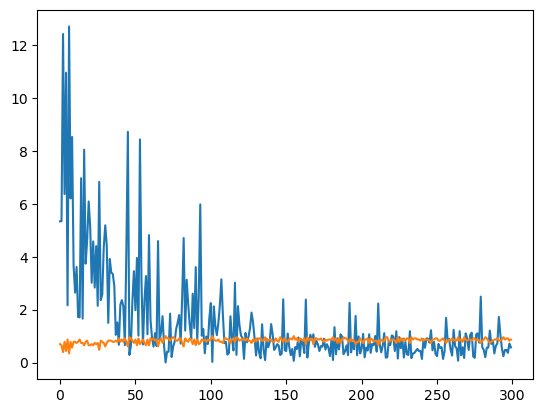

In [37]:
batch_size = 23
loss_fun = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
loss_g, acc_g = list(), list()

for i in range(300):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
    optim.zero_grad()
    Y = torch.tensor(Y_train[samp])
    out = model(torch.tensor(X_train[samp].reshape((-1, 28*28))).float())
    cat = torch.argmax(out, dim=1)
    acc = (cat == Y).float().mean()
    loss = loss_fun(out, Y)
    loss.backward()
    optim.step()
    loss, acc = loss.item(), acc.item()
    loss_g.append(loss), acc_g.append(acc)
plt.plot(loss_g)
plt.plot(acc_g)

In [39]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.8681